In [103]:
!pip install fastai
!pip install -U pyarrow

import numpy as np
import pandas as pd
import seaborn as sns

import requests
import ast
import os
import gc
import matplotlib.pyplot as plt

from fastai.vision import *
from fastai.metrics import error_rate, accuracy

Requirement already up-to-date: pyarrow in /usr/local/lib/python3.6/dist-packages (0.13.0)


In [0]:
# Will need to login to access the bucket. The following lines of code do just that
from google.colab import auth
auth.authenticate_user()

# List out all the files in the directory (Make sure that we are logged in)
gs_path = 'platform-ai-research/datasets/ProductNet/'
# !gsutil ls gs://{gs_path}

Run the following only once.

In [22]:
!mkdir images_999
!ls

adc.json  df_new_label	images_999  sample_data


In [43]:
# Pull from GS
gs_path = 'platform-ai-research/datasets/ProductNet/'

# file_name = 'df_new_label'
# remote_file = gs_path + file_name
# !gsutil cp gs://{remote_file} {file_name} 


file_name = 'images_999' # urls_20000
remote_file = gs_path + file_name
!gsutil -m cp -r gs://{remote_file} {file_name} 

Copying gs://platform-ai-research/datasets/ProductNet/urls_20000...
/ [1/1 files][  1.5 MiB/  1.5 MiB] 100% Done                                    
Operation completed over 1 objects/1.5 MiB.                                      


In [0]:
df = pd.read_feather('df_new_label')

In [0]:
url_df = pd.read_feather('urls_20000')

df = pd.merge(df, url_df,
                        left_on='asin', right_on='asin',
                        how='inner')

df.head()

imUrls = df['imUrl'].tolist()
asins = df['asin'].tolist()

In [73]:
df.head()

,asin,file_name,imUrl
0,B004SZGHGO,shoes,http://ecx.images-amazon.com/images/I/31sdKgz0...
1,B000J2ODDY,lawn,http://ecx.images-amazon.com/images/I/41YRAVPT...
2,B004HEWZ6C,clothing,http://ecx.images-amazon.com/images/I/41SuH8ym...
3,B001CS69L8,clothing,http://ecx.images-amazon.com/images/I/41uOqky0...
4,B001CPK8I6,shoes,http://ecx.images-amazon.com/images/I/41IwhJIH...


In [0]:
from PIL import Image

for url_id in zip(imUrls, asins):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of imaged
    filename = './images_999/' + asin + '.jpg'
    
    try:
        img = Image.open(filename)
    except Exception as e:
        df = df[df.asin != asin]           # if missing, remove from dataset
        with open("./missing_imgs_3.txt", "a") as f:
            f.write(asin+'\n')

In [79]:
len(df)

999

In [0]:
# !zip -r images_999.zip images_999
# files.download('images_999.zip')

Our final working `df` is `df_new_label`. It contains 999 entries and 10 classes. The folder we store the images is `images_999`. These can be found in the GS bucket.

Rerun from here after cleaning the labels.

In [0]:
pnet = pd.read_csv('ProductNet_small_prediction (2).csv')

pnet = pnet.drop_duplicates()

pnet['asin'] = pnet['file_name'].str.strip('.jpg')

pnet_asins = pnet['asin'].tolist()

In [201]:
len(pnet), len(pnet_asins)

(785, 785)

In [0]:
select_df = pnet[['asin', 'labeled_class']].copy()

In [0]:
# urls_20000 = pd.read_feather('urls_20000')

# merge with select_df
final = pd.merge(select_df, urls_20000,
                 left_on='asin', right_on='asin',
                 how='inner')

In [204]:
# len(final)

final.head()

,asin,labeled_class,imUrl
0,B006F64S7Y,jewelry,http://ecx.images-amazon.com/images/I/417zWrvK...
1,B006OHTI1K,jewelry,http://ecx.images-amazon.com/images/I/3190FJSu...
2,B005MQLE9S,shoes,http://ecx.images-amazon.com/images/I/419gMrUA...
3,B003UUM3IO,shoes,http://ecx.images-amazon.com/images/I/41dOCa7y...
4,B00DCADTKI,shoes,http://ecx.images-amazon.com/images/I/31%2BAHF...


In [0]:
# Pull images into new folder

imUrls = final['imUrl'].tolist()
asins = final['asin'].tolist()

for url_label_id in zip(imUrls, asins):
    url = url_label_id[0] # url of image
    asin = url_label_id[1] # asin of image
    
    filename = './images_784/' + asin + '.jpg'      
  
    # also check if file exists. If it does, do not reload it!
    if (not os.path.isfile(filename)):
        try:
            r = requests.get(url, allow_redirects=True)
            open(filename, 'wb').write(r.content)
            
        except Exception as e:
            final = final[final.asin != asin]           # if missing, remove from dataset
            with open("./missing_from_784.txt", "a") as f:
                f.write(asin+'\n')

In [0]:
from PIL import Image

for url_id in zip(imUrls, asins):
    url = url_id[0] # url of image
    asin = url_id[1] # asin of image
    
    filename = './images_784/' + asin + '.jpg'      
    
    try:
        img = Image.open(filename)
    except Exception as e:
        final = final[final.asin != asin]           # if missing, remove from dataset
        with open("./missing_imgs_784.txt", "a") as f:
            f.write(asin+'\n')

In [217]:
# select_df = final[['asin', 'labeled_class']]

# len(select_df)

# len(final)

final.head()

,asin,labeled_class,imUrl
0,B006F64S7Y,jewelry,http://ecx.images-amazon.com/images/I/417zWrvK...
1,B006OHTI1K,jewelry,http://ecx.images-amazon.com/images/I/3190FJSu...
2,B005MQLE9S,shoes,http://ecx.images-amazon.com/images/I/419gMrUA...
3,B003UUM3IO,shoes,http://ecx.images-amazon.com/images/I/41dOCa7y...
4,B00DCADTKI,shoes,http://ecx.images-amazon.com/images/I/31%2BAHF...


In [0]:
df = final[['asin', 'labeled_class']].copy()

In [210]:
gc.collect()

25

In [211]:
print('len of df:', len(df))

len of df: 785


In [0]:
# df = df[['asin', 'file_name']].copy()

In [0]:
# df = pd.read_feather('df_new_label')
# df.dropna(inplace=True)

In [0]:
np.random.seed(42)

tfms = get_transforms(max_lighting=0.1, max_zoom=1.05, max_warp=0.)

src = ImageDataBunch.from_df('./', 
                             df, 
                             folder='images_784', 
                             suffix='.jpg', 
                             ds_tfms=tfms, 
                             size=224, 
                             bs=64).normalize(imagenet_stats)

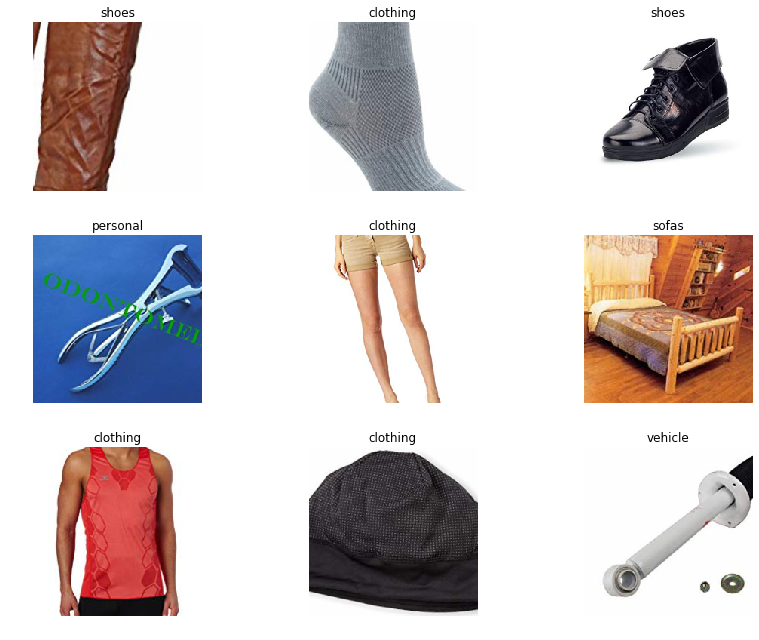

In [219]:
src.show_batch(rows=3, figsize=(12,9))

In [220]:
# # print(src.classes)
len(src.classes)

10

In [221]:
df.head()

,asin,labeled_class
0,B006F64S7Y,jewelry
1,B006OHTI1K,jewelry
2,B005MQLE9S,shoes
3,B003UUM3IO,shoes
4,B00DCADTKI,shoes


In [0]:
learn = cnn_learner(src, models.resnet34, metrics=error_rate)

In [223]:
gc.collect()

16118

In [224]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.439557,1.902434,0.649682,00:04
1,1.843017,0.798657,0.248408,00:05
2,1.341106,0.578205,0.222930,00:05
3,1.039583,0.555851,0.197452,00:05
4,0.821535,0.513619,0.178344,00:05
5,0.666156,0.519451,0.184713,00:05
6,0.554523,0.492335,0.171975,00:05
7,0.464419,0.483727,0.171975,00:05
8,0.398324,0.476410,0.171975,00:05
9,0.347898,0.479116,0.159236,00:06


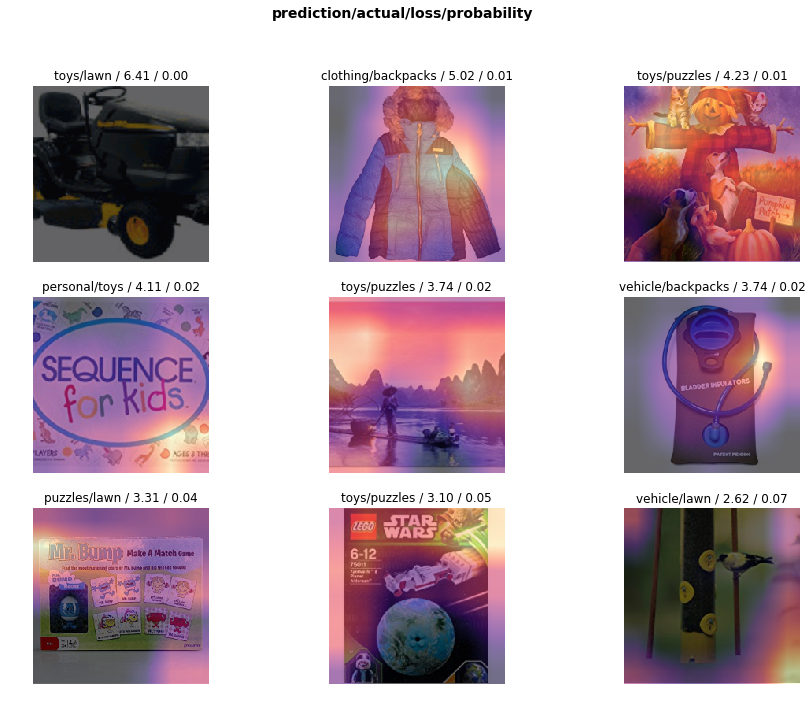

In [225]:
interp_valid = ClassificationInterpretation.from_learner(learn)
interp_valid.plot_top_losses(9, figsize=(15,11))

In [0]:
learn.unfreeze()

In [227]:
gc.collect()

14980

In [228]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.151583,0.632796,0.165605,00:05
1,0.138286,0.767450,0.203822,00:05
2,0.135703,0.696430,0.165605,00:05
3,0.138306,1.198842,0.261146,00:05
4,0.137255,1.219165,0.254777,00:05
5,0.130907,0.811101,0.229299,00:05
6,0.118949,0.818181,0.191083,00:05
7,0.110467,0.798239,0.197452,00:05
8,0.099184,0.735931,0.171975,00:05
9,0.088264,0.717737,0.165605,00:06


In [232]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


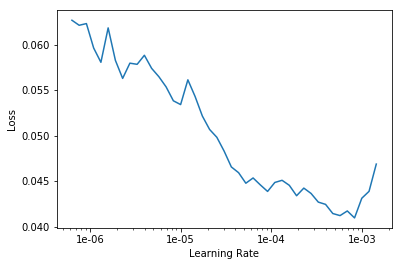

In [233]:
learn.recorder.plot()

In [0]:
learn.save('before_lr')

In [235]:
learn.fit_one_cycle(10, 5e-5)

epoch,train_loss,valid_loss,error_rate,time
0,0.038476,0.705952,0.165605,00:05
1,0.036251,0.676809,0.159236,00:05
2,0.031851,0.654804,0.152866,00:05
3,0.031657,0.629627,0.152866,00:05
4,0.029257,0.623911,0.146497,00:06
5,0.027473,0.612916,0.152866,00:05
6,0.024088,0.601481,0.152866,00:06
7,0.022486,0.594922,0.146497,00:06
8,0.019733,0.586399,0.133758,00:05
9,0.018909,0.585014,0.140127,00:05


Code below is taken from the NYC cohort. Many thanks to them.

In [0]:
tta_mod = []
for i in np.arange(0.7, 1.4, 0.05):
   tta_mod.append((i, accuracy(*learn.TTA(scale=i))))

In [0]:
sorted(tta_mod, key=lambda e:e[1], reverse=True)

[(0.8500000000000001, tensor(0.7236)),
 (1.0000000000000002, tensor(0.7236)),
 (0.8, tensor(0.7186)),
 (0.9000000000000001, tensor(0.7186)),
 (0.9500000000000002, tensor(0.7186)),
 (1.0500000000000003, tensor(0.7186)),
 (1.1500000000000004, tensor(0.7186)),
 (1.1000000000000003, tensor(0.7136)),
 (1.2500000000000004, tensor(0.7136)),
 (1.3000000000000005, tensor(0.7136)),
 (1.3500000000000005, tensor(0.7136)),
 (0.7, tensor(0.7085)),
 (1.2000000000000004, tensor(0.7085)),
 (0.75, tensor(0.6935))]